In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymrmr
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import skew
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')
pd.set_option('display.max_columns', None)

### 資料觀察
- Z_CostContact及Z_Revenue找不到意義，且所有值都相同，所以不需要
- Income有少量缺失值
- Education要標籤化
- Marital_Status要標籤化
- ID可以拿掉
- Year_Birth要改成年紀
- Dt_Customer可做成註冊多久 
- 新增總花費
- 用Teenhome,Kidhome新增為家庭

In [3]:
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
df.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

### 鎖定分析方向
- 以賺錢及節流為主要分析方向
- 賺錢 >> 客戶分群 >> 產品推薦 >> 節流 >> 客戶活動成效 >> 降低流失客戶行銷
- 

### 資料探勘及預處理
- 1.處理類別型及有缺值
- 2.新增年齡
- 3.新增累計註冊天數

#### df['Dt_Customer']
- 創建Be_Customer用today - df['Dt_Customer']

In [6]:
today = datetime.today()
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Be_Customer'] = (today - df['Dt_Customer']).dt.days

C:\Users\User\AppData\Local\Temp\ipykernel_8948\746445318.py:2: UserWarning: Parsing '21-08-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
C:\Users\User\AppData\Local\Temp\ipykernel_8948\746445318.py:2: UserWarning: Parsing '19-01-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
C:\Users\User\AppData\Local\Temp\ipykernel_8948\746445318.py:2: UserWarning: Parsing '13-11-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
C:\Users\User\AppData\Local\Temp\ipykernel_8948\746445318.py:2: UserWarning: Parsing '13-03-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_

#### Spent
- 創建df["Spent"]用購買總類的相加

In [7]:
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

#### Children&Parent
- 創建df['Children']用df['Kidhome'], df['Teenhome']相加
- 創建df['Parent']用df['Children']判斷是否為父母

In [8]:
df['Children'] = df['Kidhome']+ df['Teenhome']
df['Parent'] = np.where(df['Children'] > 0, 1, 0)

#### df['Marital_Status']
- 將Alone, Absurd, YOLO, Widow, Divorced 納入Single
- Married 納入Together

In [9]:
df['Marital_Status'].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [10]:
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO', 'Widow', 'Divorced'], 'Single')
df['Marital_Status'] = df['Marital_Status'].replace({'Married': 'Together'})

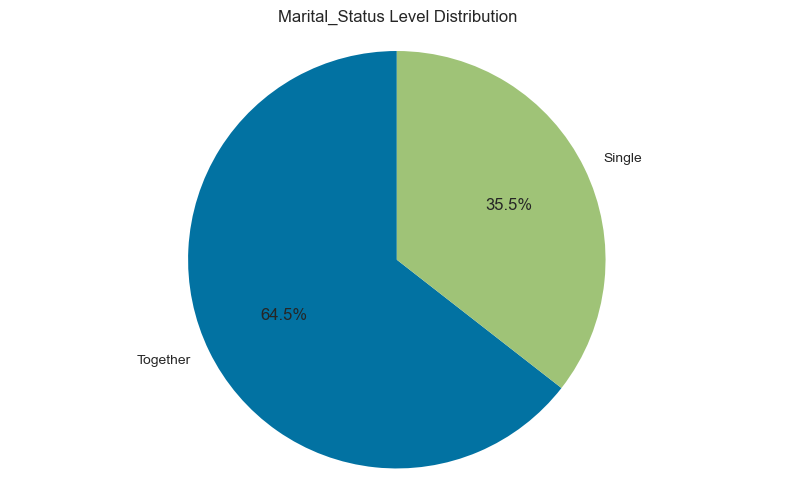

In [11]:
Marital_counts = df['Marital_Status'].value_counts()
plt.figure(figsize = (10, 6))
plt.pie(Marital_counts.values, labels = Marital_counts.index, autopct='%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Marital_Status Level Distribution')
plt.show()

In [12]:
label_mapping = {'Together': 0, 'Single': 1}
df['Marital_Status'] = df['Marital_Status'].replace(label_mapping)
df['Marital_Status'].value_counts()

0    1444
1     796
Name: Marital_Status, dtype: int64

#### df['Income']
- 將缺值補入中位數

In [13]:
df['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [14]:
df['Income'].fillna(51381.5, inplace = True)
df['Income'].isna().sum()

0

#### df['Education']
- 轉為有序數值

In [15]:
df['Education'].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

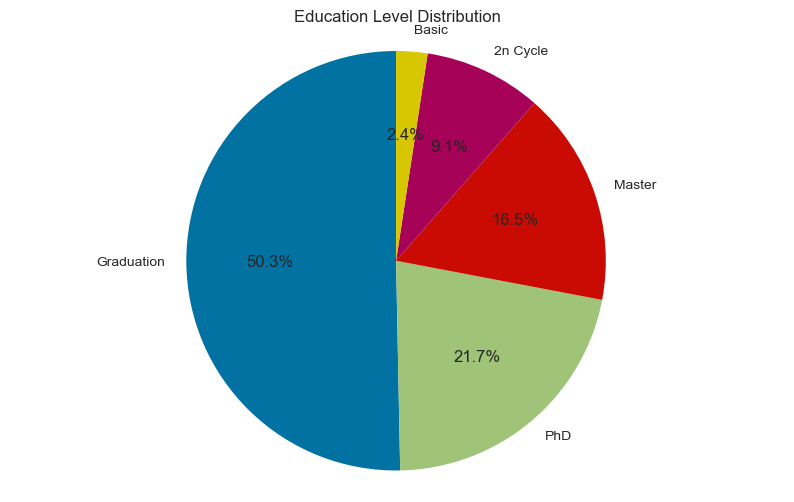

In [17]:
education_counts = df['Education'].value_counts()
plt.figure(figsize = (10, 6))
plt.pie(education_counts.values, labels = education_counts.index, autopct='%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Education Level Distribution')
plt.show()

In [18]:
label_mapping = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD':4}
df['Education'] = df['Education'].replace(label_mapping)
df['Education'].value_counts()

2    1127
4     486
3     370
1     203
0      54
Name: Education, dtype: int64

#### df['Year_Birth']
- 用今年-Year_Birth算年紀

In [19]:
df['Age'] = 2022-df['Year_Birth']

In [20]:
df.drop(['Year_Birth','Z_CostContact', 'Z_Revenue', 'ID', 'Dt_Customer'], axis = 1, inplace = True)

In [21]:
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Be_Customer,Spent,Children,Parent,Age
0,2,1,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,4017,1617,0,0,65
1,2,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,3171,27,2,1,68
2,2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,3518,776,0,0,57
3,2,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,3111,53,1,1,38
4,4,0,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,3367,422,1,1,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2,0,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,3587,1341,1,1,55
2236,4,0,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,3107,444,3,1,76
2237,2,1,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,3361,1241,0,0,41
2238,3,0,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,3362,843,1,1,66


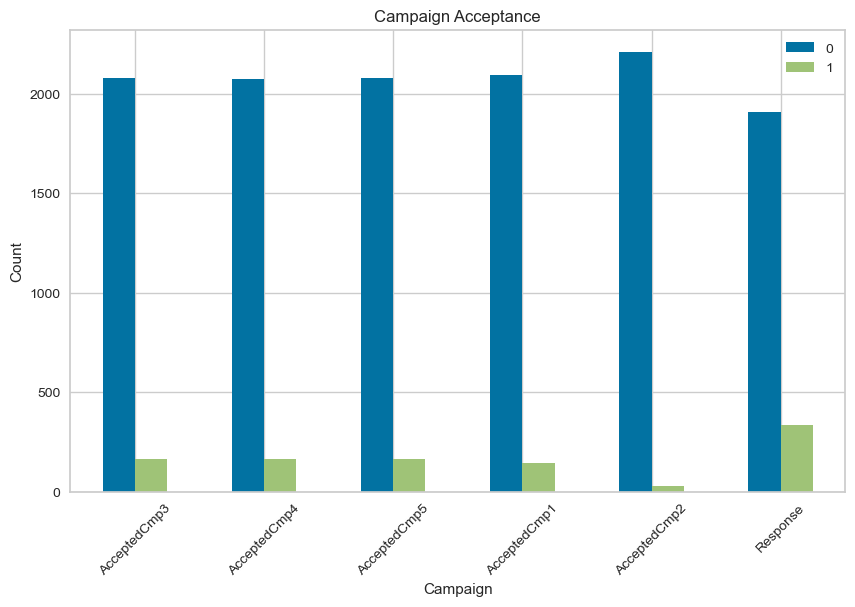

In [22]:
campaign_columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']
campaign_data = df[campaign_columns]
campaign_counts = campaign_data.apply(lambda x: pd.Series([len(x) - x.sum(), x.sum()], index=['0', '1']))
fig, ax = plt.subplots(figsize=(10, 6))
campaign_counts.T.plot(kind='bar', ax=ax)
plt.title('Campaign Acceptance')
plt.xlabel('Campaign')
plt.ylabel('Count')
plt.xticks(np.arange(len(campaign_columns)), campaign_columns, rotation=45)
plt.show()

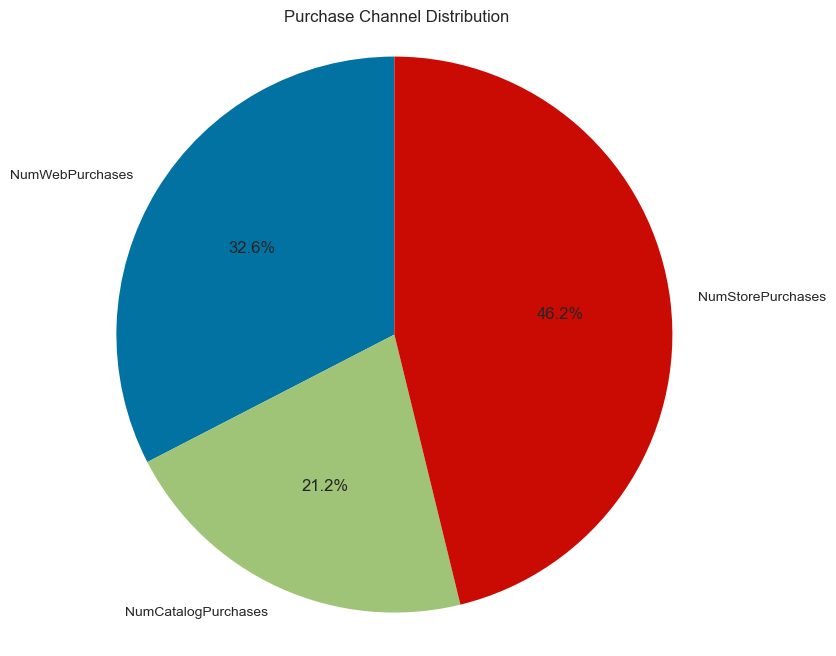

In [24]:
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
purchase_data = df[purchase_columns]
purchase_totals = purchase_data.sum()

plt.figure(figsize=(8, 8))
plt.pie(purchase_totals, labels=purchase_columns, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Purchase Channel Distribution')
plt.show()

### 常態分布

#### 檢查偏離值
- 'Income'不適合用boxcox轉常態分佈，決定排除四分位數之外的極值
- 'NumStorePurchases'符合常態分佈
- 'Recency'是時間型不能隨意調整

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-p

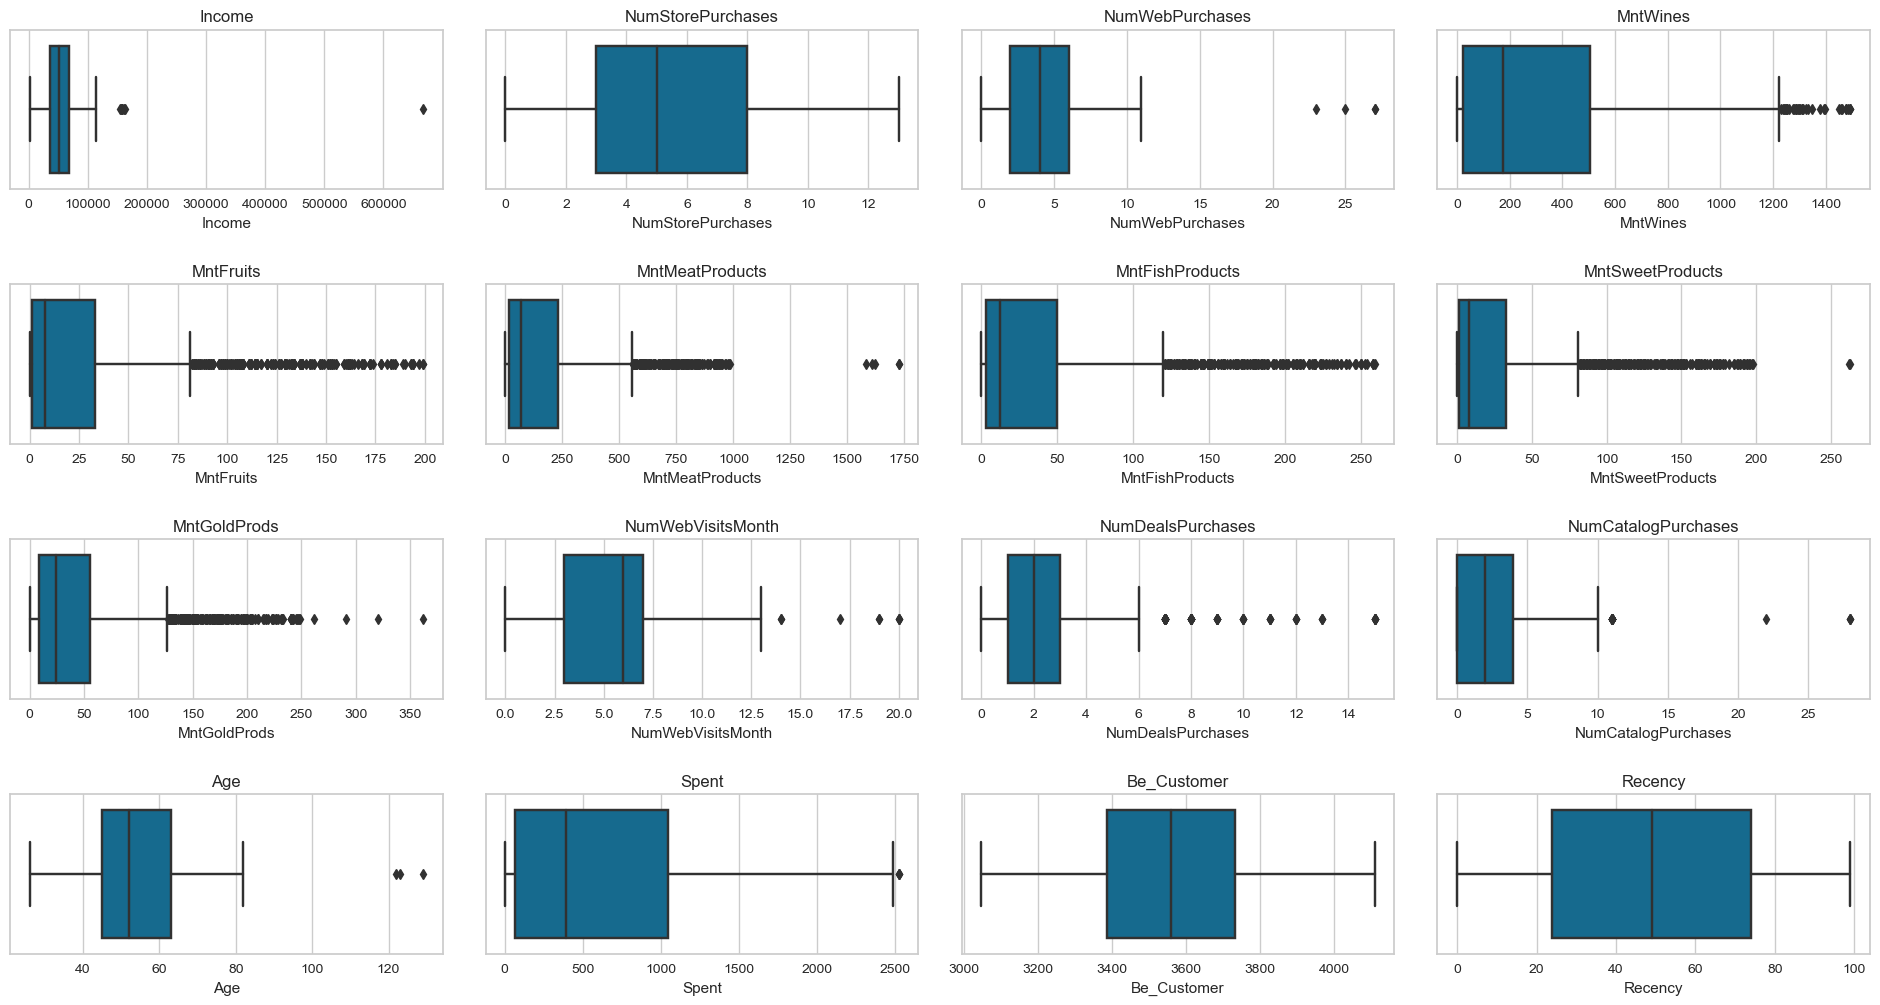

In [25]:
features = ['Income',  'NumStorePurchases', 'NumWebPurchases',
            'MntWines', 'MntFruits', 'MntMeatProducts',
            'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
            'NumWebVisitsMonth', 'NumDealsPurchases', 'NumCatalogPurchases',
            'Age', 'Spent', 'Be_Customer','Recency']
fig, axes = plt.subplots(4, 4, figsize=(24, 12))

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.boxplot(df[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)
plt.subplots_adjust(hspace=0.6, wspace=0.1)
plt.show()

In [26]:
df = df[(df['Income'] < 600000)]
df = df[(df['Age'] < 90)]

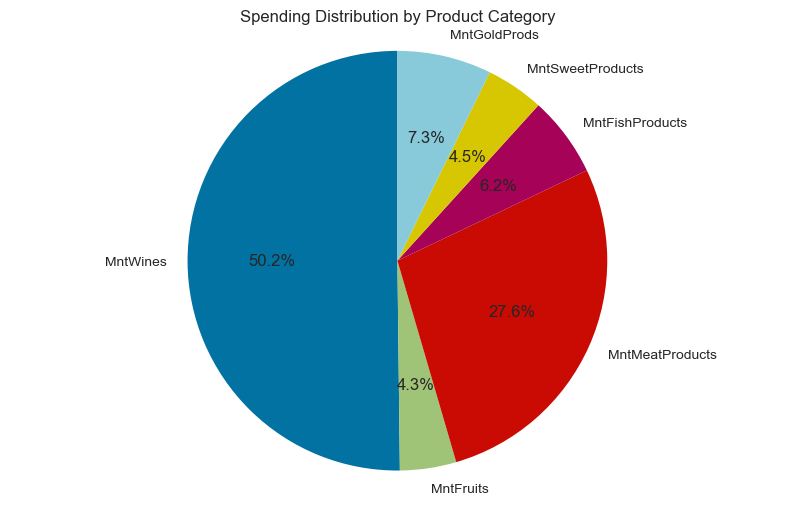

In [27]:
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
total_values = [df[product_column].sum() for product_column in product_columns]

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(total_values, labels=product_columns, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Spending Distribution by Product Category')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_8948\2751829334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['AgeGroup'] = pd.cut(product_data['Age'], bins=bins, labels=labels)


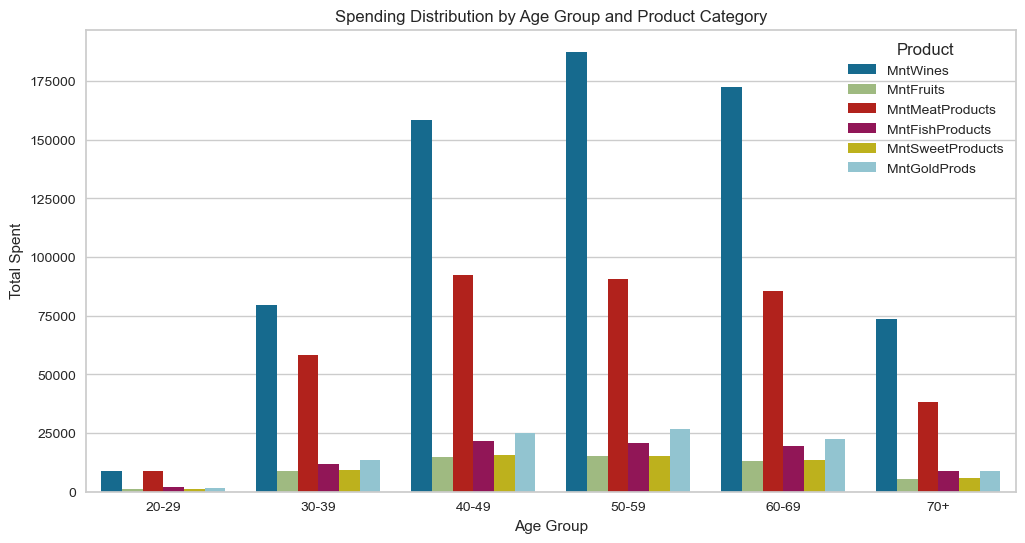

In [28]:
product_data = df[product_columns + ['Age']]
bins = [20, 30, 40, 50, 60, 70, 100]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70+']
product_data['AgeGroup'] = pd.cut(product_data['Age'], bins=bins, labels=labels)
grouped_totals = product_data.groupby('AgeGroup')[product_columns].sum().reset_index()
melted_data = grouped_totals.melt(id_vars=['AgeGroup'],
                                  value_vars=product_columns,
                                  var_name='Product',
                                  value_name='TotalSpent')
plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='TotalSpent', hue='Product', data=melted_data)
plt.title('Spending Distribution by Age Group and Product Category')
plt.xlabel('Age Group')
plt.ylabel('Total Spent')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_8948\1338177851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_data['AgeGroup'] = pd.cut(purchase_data['Age'], bins = bins, labels = labels)


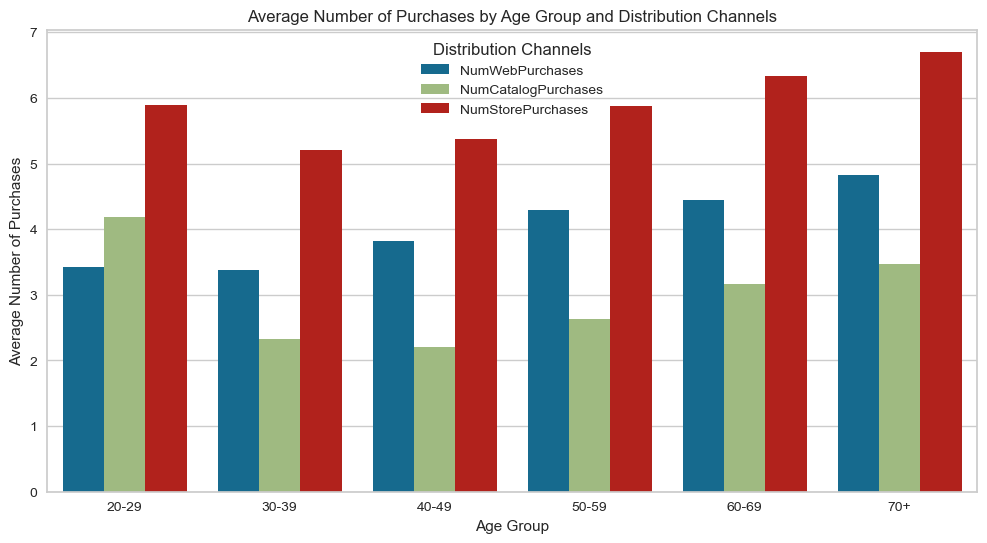

In [29]:
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Age']
purchase_data = df[purchase_columns]
bins = [20, 30, 40, 50, 60, 70, 100]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70+']
purchase_data['AgeGroup'] = pd.cut(purchase_data['Age'], bins = bins, labels = labels)
age_group_purchase_data = purchase_data.groupby('AgeGroup')[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].mean().reset_index()
melted_data = age_group_purchase_data.melt(id_vars = ['AgeGroup'], 
                                           value_vars = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], 
                                           var_name = 'Distribution Channels', value_name = 'AveragePurchaseCount')

plt.figure(figsize = (12, 6))
sns.barplot(x = 'AgeGroup', 
            y = 'AveragePurchaseCount', 
            hue = 'Distribution Channels', 
            data = melted_data)
plt.title('Average Number of Purchases by Age Group and Distribution Channels')
plt.xlabel('Age Group')
plt.ylabel('Average Number of Purchases')
plt.show()

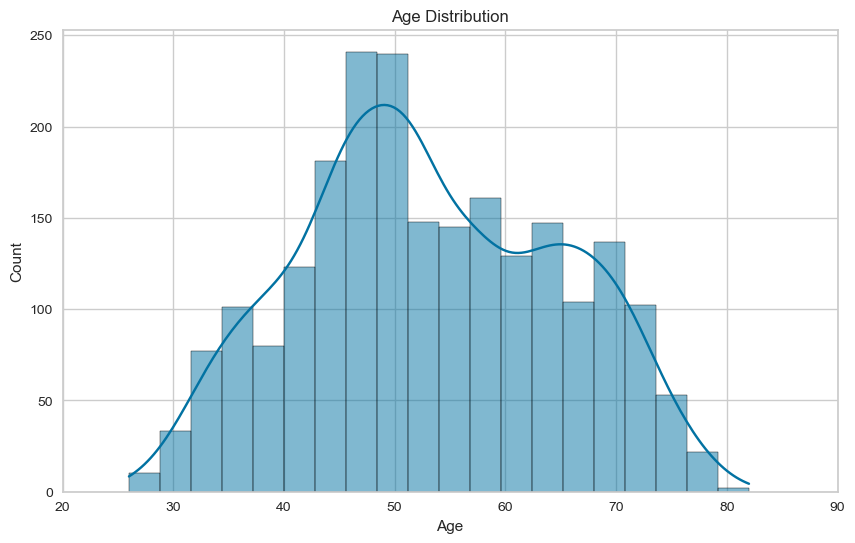

In [30]:
ages = df['Age']
max_age = ages.max()
plt.figure(figsize = (10, 6))
sns.histplot(data = ages, bins=20, kde = True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(range(20, ages.max() + 10, 10))
plt.show()

In [31]:
def boxcox_transform(df, columns):
    lambdas = {}
    for column in columns:
        print(f"Skewness of {column} before transformation:", skew(df[column]))
        lambd = boxcox_normmax(df[column] + 1)
        df[column] = boxcox1p(df[column], lambd)
        lambdas[column] = lambd
        print(f"Skewness of {column} after transformation:", skew(df[column]))
        print('='*30)
    return df, lambdas

In [32]:
columns_to_transform = ['NumWebPurchases', 'MntWines', 'MntFruits', 'MntMeatProducts', 
                        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                        'NumWebVisitsMonth','NumDealsPurchases', 'NumCatalogPurchases',
                        'Age', 'Spent', 'Be_Customer']
df_transformed, lambdas = boxcox_transform(df, columns_to_transform)

Skewness of NumWebPurchases before transformation: 1.380207049408233
Skewness of NumWebPurchases after transformation: 0.035500189591380564
Skewness of MntWines before transformation: 1.1752469053420302
Skewness of MntWines after transformation: -0.06694413679933839
Skewness of MntFruits before transformation: 2.1028295698494177
Skewness of MntFruits after transformation: 0.14676086078661157
Skewness of MntMeatProducts before transformation: 2.0838832753700847
Skewness of MntMeatProducts after transformation: -0.031575565716501545
Skewness of MntFishProducts before transformation: 1.9186813422731241
Skewness of MntFishProducts after transformation: 0.11543590668074706
Skewness of MntSweetProducts before transformation: 2.1342411463060125
Skewness of MntSweetProducts after transformation: 0.15987188948552344
Skewness of MntGoldProds before transformation: 1.8838713876279511
Skewness of MntGoldProds after transformation: -0.014168482450712616
Skewness of NumWebVisitsMonth before transfor

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-p

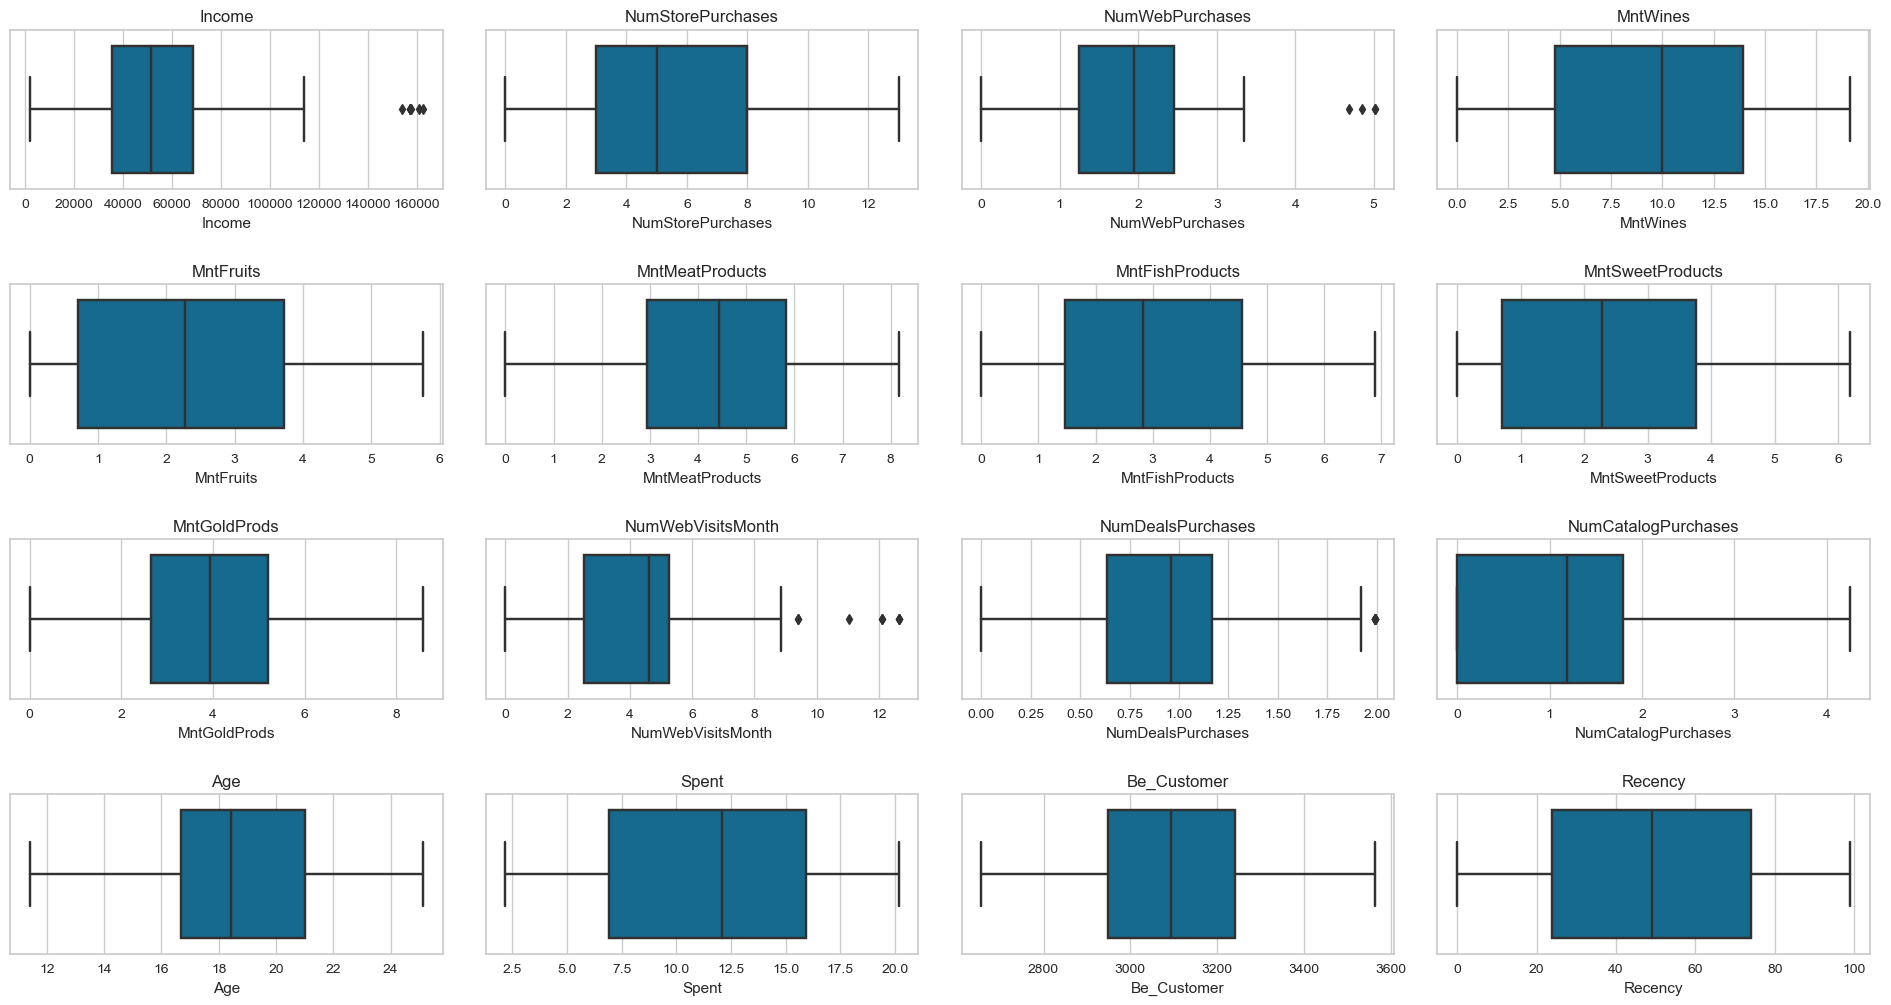

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.boxplot(df[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)
plt.subplots_adjust(hspace=0.6, wspace=0.1)
plt.show()

#### 極端值排除
- boxcox1p校正後，移除'Income', 'NumWebVisitsMonth', 'NumDealsPurchases', 'NumWebPurchases'四分位数之外的极值

In [34]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df  = df.loc[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [35]:
df = remove_outliers(df, 'Income')
df = remove_outliers(df, 'NumWebVisitsMonth')
df = remove_outliers(df, 'NumDealsPurchases')
df = remove_outliers(df, 'NumWebPurchases')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-p

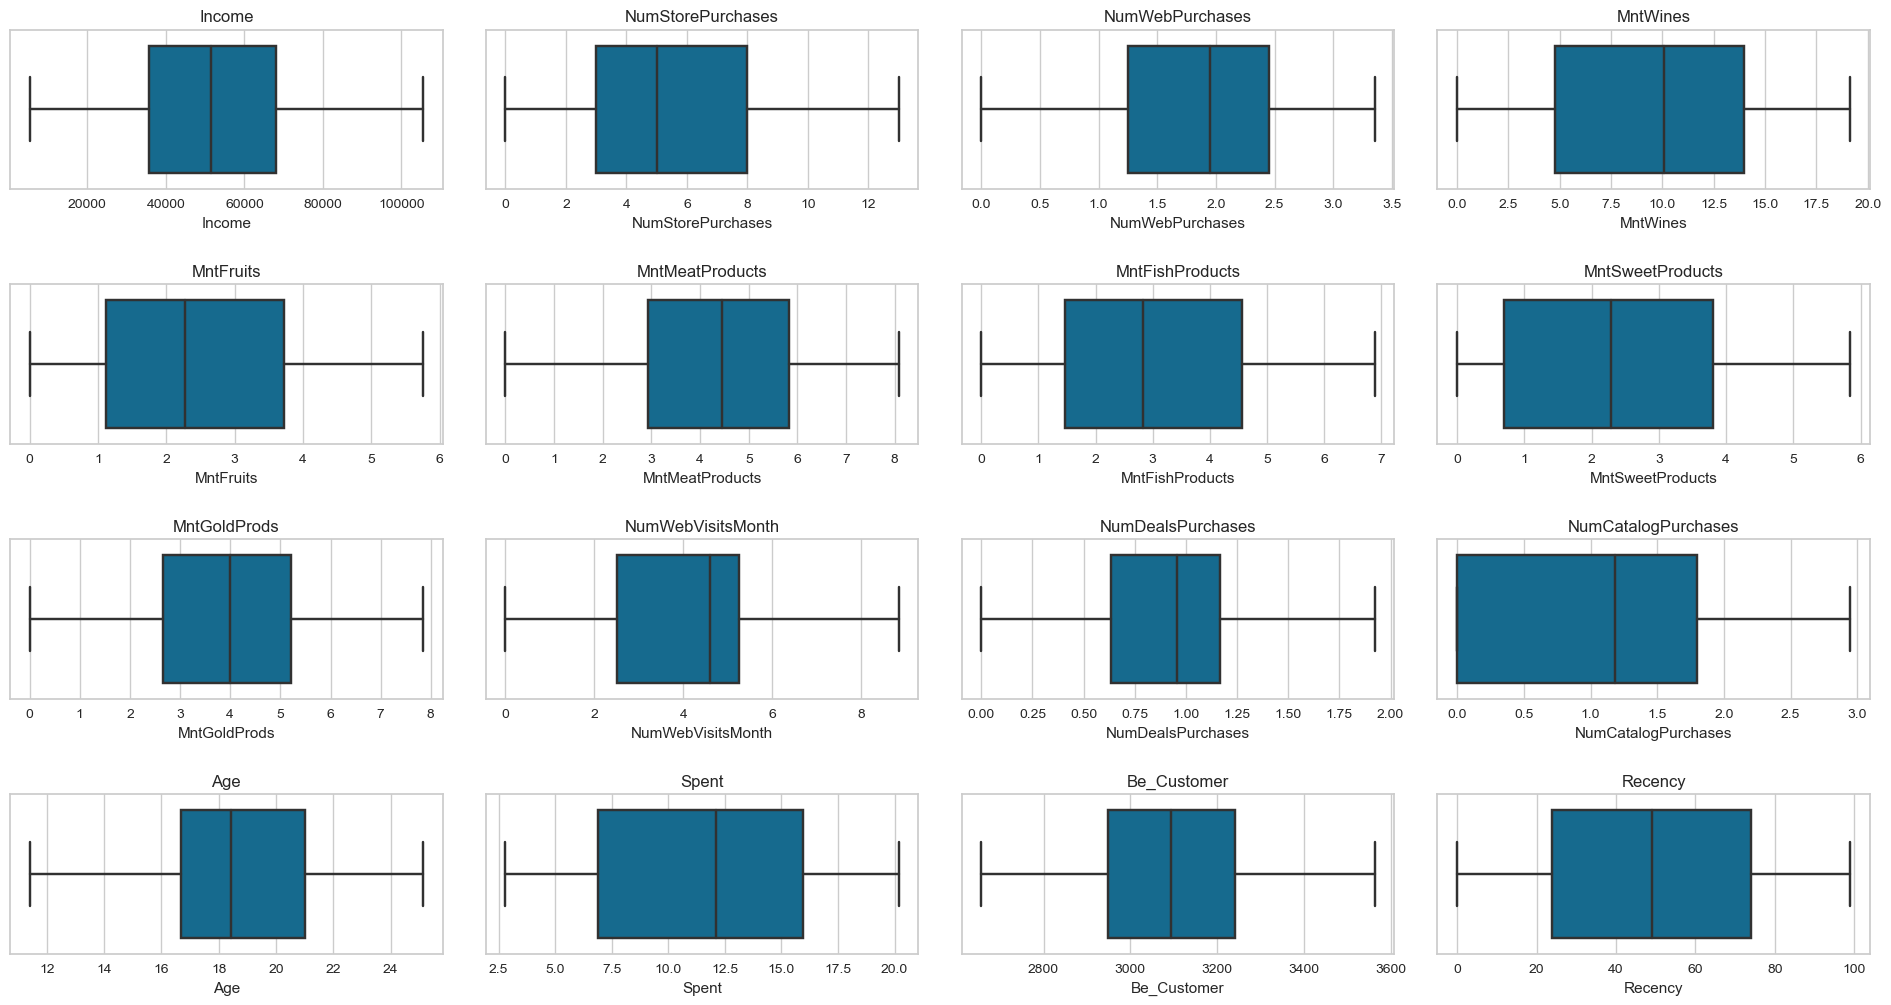

In [36]:
fig, axes = plt.subplots(4, 4, figsize = (24, 12))
for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.boxplot(df[feature], ax = axes[row, col])
    axes[row, col].set_title(feature)
plt.subplots_adjust(hspace = 0.6, wspace = 0.1)
plt.show()

In [37]:
def boxcox_inverse_transform(df, columns, lambdas):
    for column in columns:
        df[column] = inv_boxcox(df[column], lambdas[column])
    return df

In [38]:
df_boxcox = df.copy()
origin_df = boxcox_inverse_transform(df_boxcox, columns_to_transform, lambdas)

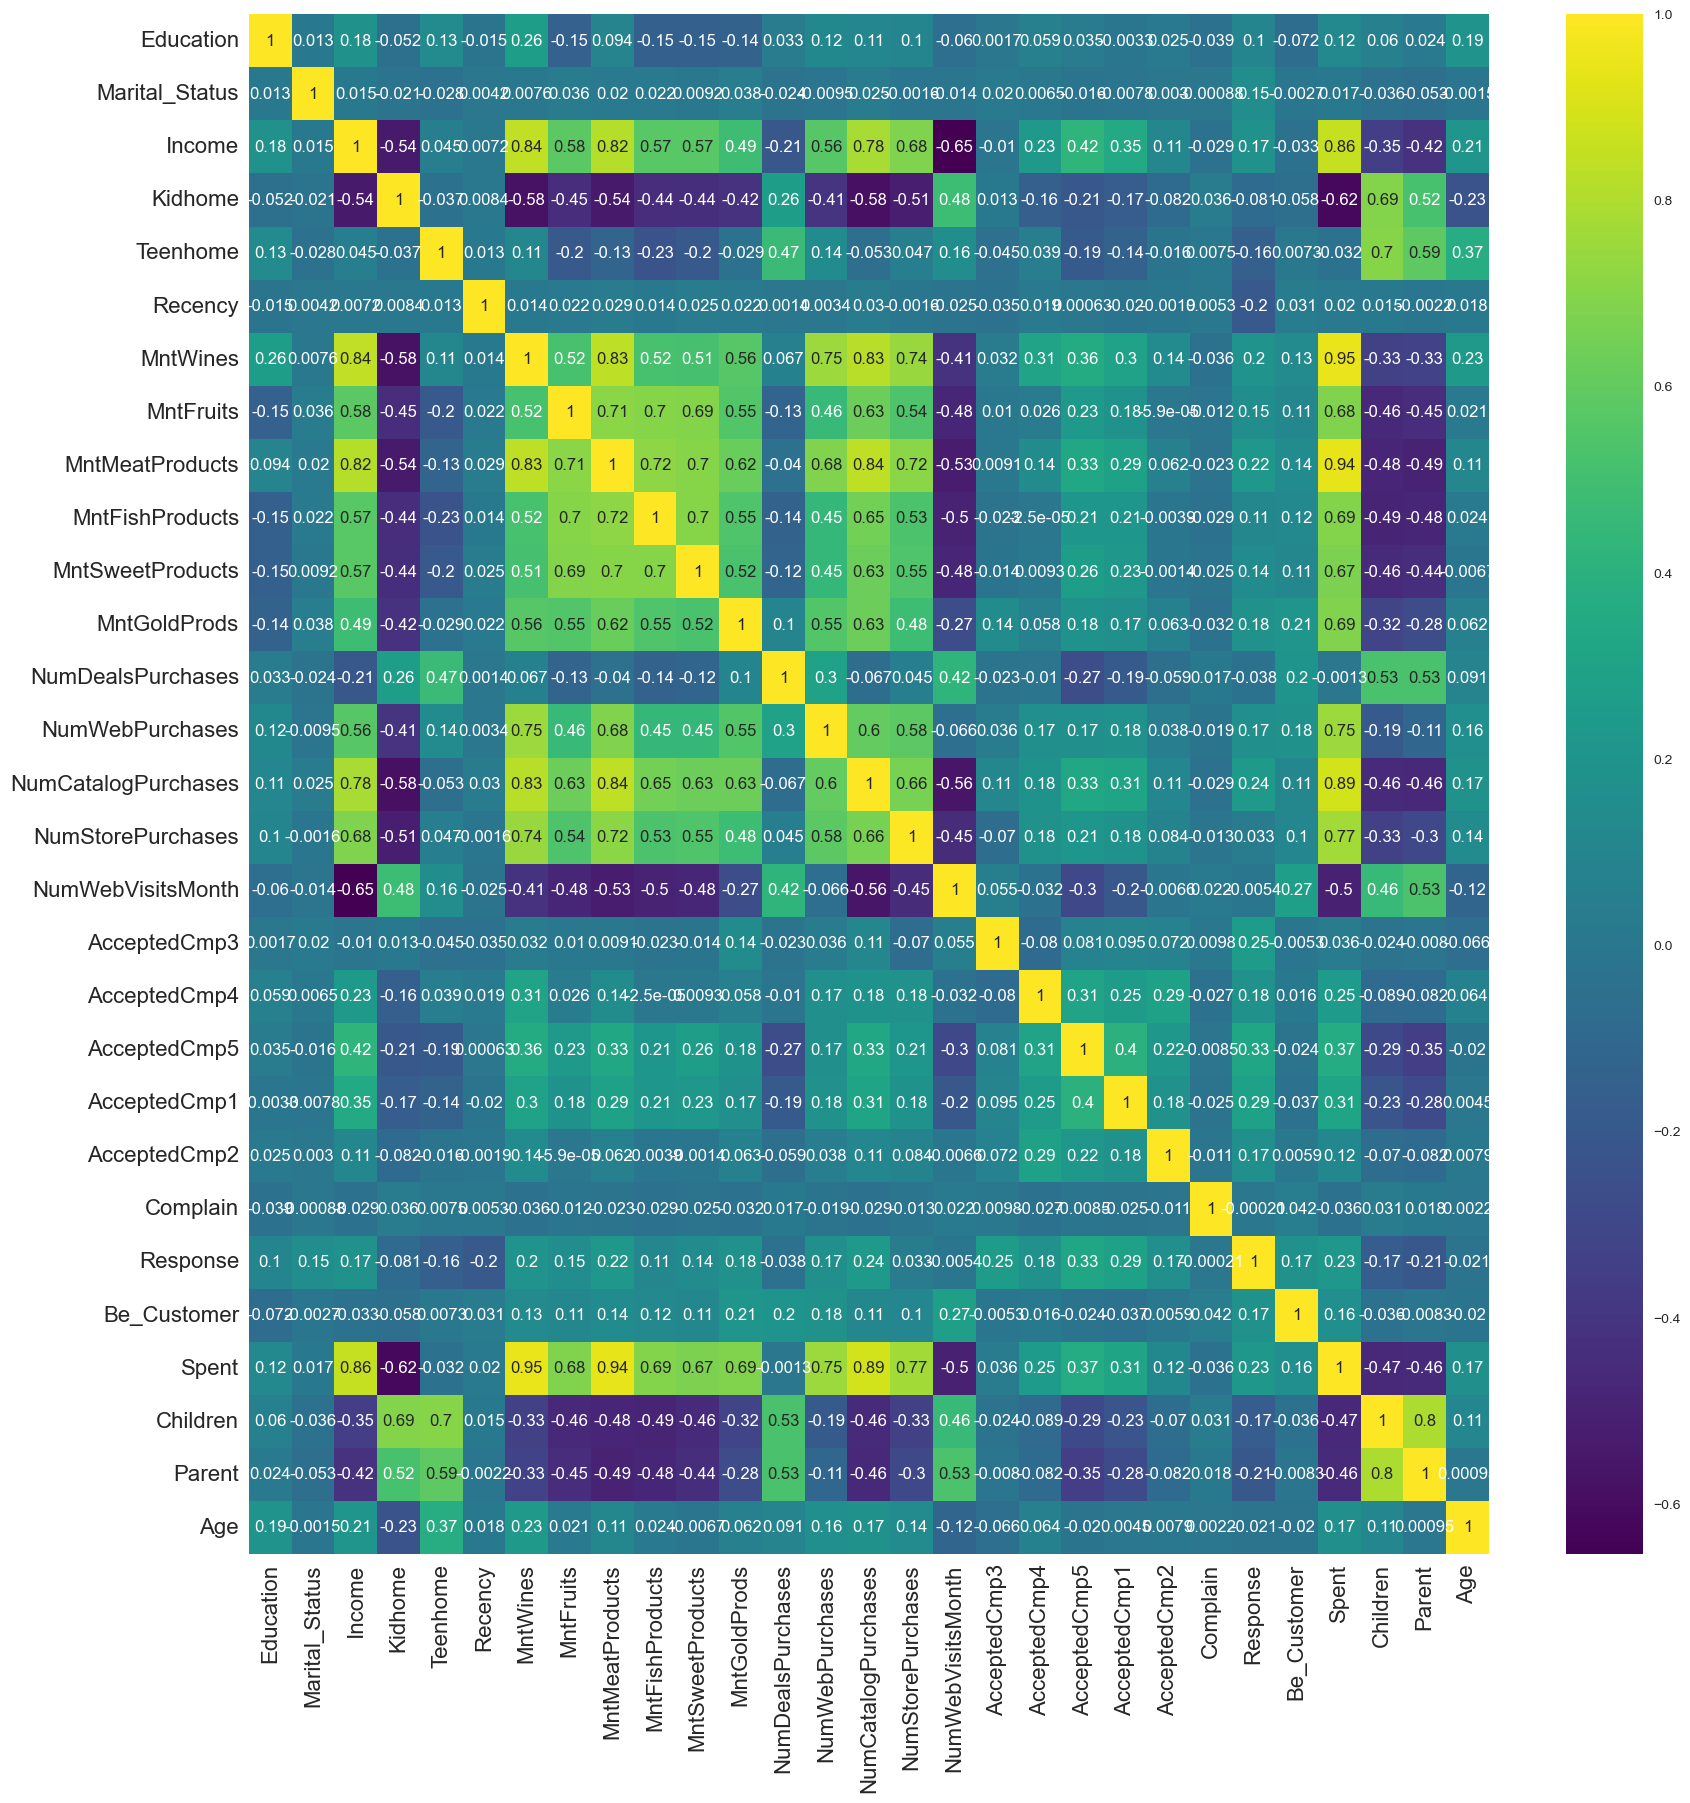

In [39]:
cor = df.corr()
plt.figure(figsize = (20, 20))  
heatmap = sns.heatmap(cor, annot = True, cmap = 'viridis')
heatmap.tick_params(axis = 'x', labelsize = 16) 
heatmap.tick_params(axis = 'y', labelsize = 16)
plt.show()

In [40]:
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Be_Customer,Spent,Children,Parent,Age
0,2,1,58138.0,0,0,58,14.941937,4.814581,6.808517,6.274394,4.881629,5.953422,1.168012,2.859264,2.827035,4,5.244649,0,0,0,0,0,0,1,3484.569720,17.932388,0,0,21.465900
1,2,1,46344.0,1,1,38,3.359723,0.700618,1.992253,1.144532,0.702085,2.192813,0.958313,0.751472,0.726293,2,3.926710,0,0,0,0,0,0,0,2763.386903,4.849279,2,1,22.133700
2,2,0,71613.0,0,0,26,13.243886,4.158107,5.147057,5.647749,3.274159,4.757599,0.635417,2.859264,1.183428,10,3.233075,0,0,0,0,0,0,0,3059.595435,14.662979,0,0,19.629741
3,2,0,26646.0,1,0,26,3.359723,1.650100,3.158981,2.623943,1.422352,1.999753,0.958313,1.249921,0.000000,4,4.595827,0,0,0,0,0,0,0,2712.107007,6.281118,1,1,14.856303
4,4,0,58293.0,1,0,94,9.946409,4.014145,5.065180,4.455028,3.545653,3.291577,1.438658,2.217483,1.523137,6,3.926710,0,0,0,0,0,0,0,2930.771277,12.313774,1,1,15.657628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2,0,61223.0,0,1,46,15.439341,4.014145,5.550582,4.337129,5.226269,7.826109,0.958313,3.036065,1.523137,4,3.926710,0,0,0,0,0,0,0,3118.425939,17.049708,1,1,19.156873
2236,4,0,64014.0,2,1,56,13.049805,0.000000,3.580064,0.000000,0.000000,2.515348,1.614424,2.859264,1.183428,5,5.244649,0,0,0,1,0,0,0,2708.687666,12.498255,3,1,23.865785
2237,2,1,56981.0,0,0,91,16.603218,4.135318,5.749417,3.990839,2.690210,3.931818,0.635417,1.249921,1.523137,13,4.595827,0,1,0,0,0,0,0,2925.650142,16.694397,0,0,15.657628
2238,3,0,69245.0,0,1,8,13.262907,3.622656,5.733643,5.193659,3.660965,5.346061,0.958313,2.454451,2.024678,10,2.508760,0,0,0,0,0,0,0,2926.503677,15.006651,1,1,21.689680


In [41]:
features = pymrmr.mRMR(df, 'MIQ', 29)
mrmr = df[features]
cor = mrmr.corr()

for i in range(len(features)):
    for j in range(i, len(features)):
        cor.iloc[i, j] = None

cor = cor.unstack().dropna().sort_values(ascending = False)

### 特徵篩選及統一

### 特徵縮放

In [42]:
df_copy = df.copy()

In [43]:
cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df_copy = df_copy.drop(cols, axis = 1)

In [44]:
df_copy = pd.DataFrame(StandardScaler().fit_transform(df_copy), columns = df_copy.columns)

In [45]:
df_copy

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Be_Customer,Spent,Children,Parent,Age
0,-0.455792,1.349687,0.310636,-0.825377,-0.932719,0.306268,1.061509,1.448368,1.420680,1.668995,1.433359,1.095470,0.723289,1.366464,1.929981,-0.572184,0.746452,1.973308,1.337840,-1.266991,-1.589676,1.012978
1,-0.455792,1.349687,-0.268863,1.030674,0.905335,-0.384973,-1.215550,-0.988524,-1.399802,-0.887373,-0.975308,-0.953139,0.100608,-1.396399,-0.450990,-1.192843,-0.084277,-1.669314,-1.426247,1.394351,0.629059,1.248513
2,-0.455792,-0.740912,0.972731,-0.825377,-0.932719,-0.799717,0.727672,1.059509,0.447702,1.356719,0.506976,0.444040,-0.858201,1.366464,0.067124,1.289795,-0.521491,-0.173195,0.647107,-1.266991,-1.589676,0.365359
3,-0.455792,-0.740912,-1.236725,1.030674,-0.932719,-0.799717,-1.215550,-0.426101,-0.716547,-0.150137,-0.560219,-1.058309,0.100608,-0.743039,-1.274168,-0.572184,0.337484,-1.928324,-1.123741,0.063680,0.629059,-1.318247
4,1.539425,-0.740912,0.318252,1.030674,-0.932719,1.550502,0.079390,0.974233,0.399753,0.762349,0.663438,-0.354582,1.526947,0.525227,0.452149,0.048476,-0.084277,-0.823873,0.150787,0.063680,0.629059,-1.035617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,-0.455792,-0.740912,0.462218,-0.825377,0.905335,-0.108476,1.159298,0.974233,0.684013,0.703597,1.631974,2.115625,0.100608,1.598212,0.452149,-0.572184,-0.084277,0.123952,1.151355,0.063680,0.629059,0.198577
2211,1.539425,-0.740912,0.599354,2.886724,0.905335,0.237144,0.689516,-1.403533,-0.469954,-1.457728,-1.379919,-0.777436,2.048867,1.366464,0.067124,-0.261854,0.746452,-1.945595,0.189763,2.725023,0.629059,1.859425
2212,-0.455792,1.349687,0.253787,-0.825377,-0.932719,1.446815,1.388116,1.046009,0.800454,0.531030,0.170447,-0.005808,-0.858201,-0.743039,0.452149,2.220784,0.337484,-0.849739,1.076288,-1.266991,-1.589676,-1.035617
2213,0.541816,-0.740912,0.856380,-0.825377,0.905335,-1.421834,0.731412,0.742336,0.791216,1.130432,0.729892,0.764608,0.100608,0.835841,1.020593,1.289795,-0.978044,-0.845428,0.719715,0.063680,0.629059,1.091906


### 分析說明

### 資料的使用
#### 高度正相關性
##### 消費行為:
- MntWines 和 Spent
- MntMeatProducts 和 Spent
- Spent 和 NumCatalogPurchases
- MntMeatProducts 和 NumCatalogPurchases
- MntWines 和 MntMeatProducts
- MntWines 和 NumCatalogPurchases

##### 收入：
- Income 和 Spent
- Income 和 MntWines
- Income 和 MntMeatProducts

#### 中度負相關性
##### 家庭狀況：
- NumStorePurchases 和 Kidhome
- Income 和 Kidhome
- MntMeatProducts 和 Kidhome
- MntWines 和 Kidhome
- NumCatalogPurchases 和 Kidhome
- Spent 和 Kidhome

##### 網站行為：
- Spent 和 NumWebVisitsMonth
- MntMeatProducts 和 NumWebVisitsMonth
- NumWebVisitsMonth 和 NumCatalogPurchases
- Income 和 NumWebVisitsMonth

### 機器學習

#### 降維處理

In [46]:
pca = PCA(n_components = 3)
pca.fit(df_copy)
PCA_df = pd.DataFrame(pca.transform(df_copy), columns = (['col1', 'col2', 'col3']))
PCA_df

,col1,col2,col3
0,-4.155515,0.067929,2.169951
1,3.693307,0.165653,-1.715447
2,-3.302412,-1.243135,0.070887
3,3.057556,-1.540836,0.245972
4,-0.631748,0.569353,0.469510
...,...,...,...
2210,-2.720739,1.558511,1.062801
2211,2.371393,4.013426,-2.138376
2212,-2.772024,-1.755849,0.079293
2213,-2.801072,1.461128,-1.142490


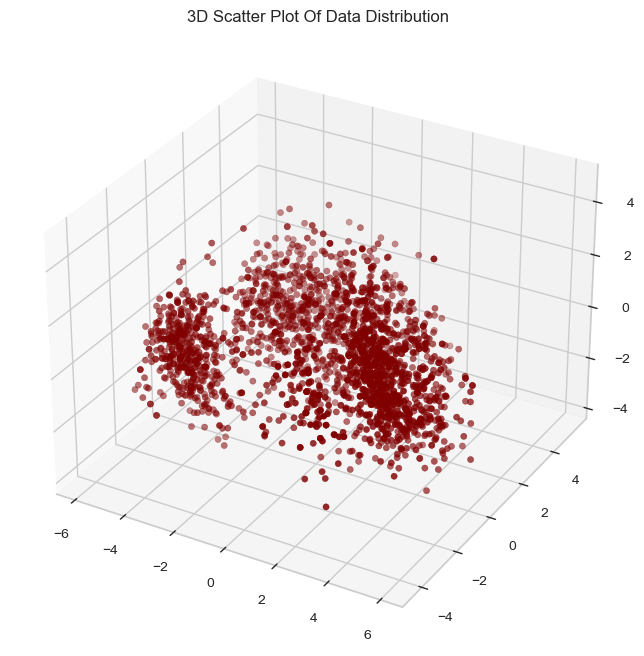

In [47]:
x = PCA_df['col1']
y = PCA_df['col2']
z = PCA_df['col3']

fig = plt.figure(figsize = (10,8))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, c = 'maroon', marker = 'o' )
ax.set_title('3D Scatter Plot Of Data Distribution')
plt.show()

#### KMeans

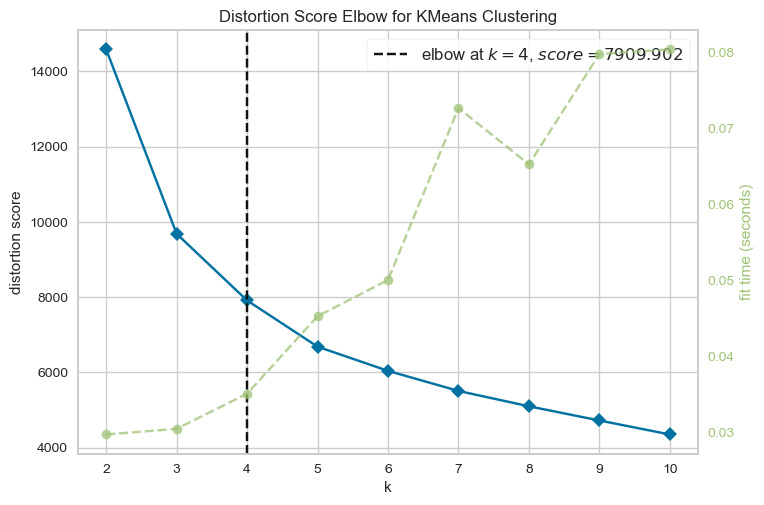

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
ElbowM = KElbowVisualizer(KMeans(), k = 10)
ElbowM.fit(PCA_df)
ElbowM.show()

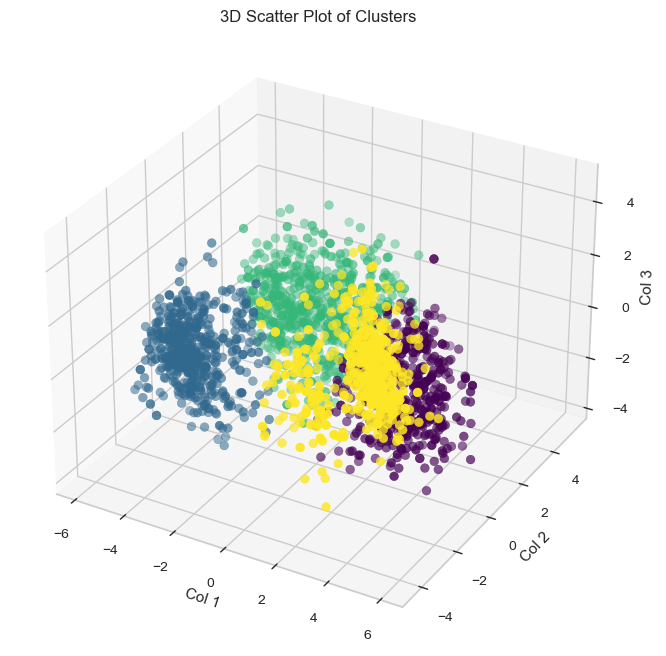

In [49]:
bestK = ElbowM.elbow_value_
kmeans = KMeans(n_clusters = bestK)
kmeans.fit(PCA_df)
labels = kmeans.labels_
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d')
PCA_df['Clusters'] = labels
x = PCA_df['col1']
y = PCA_df['col2']
z = PCA_df['col3']
ax.scatter(x, y, z, s = 40, c = PCA_df['Clusters'], marker = 'o', cmap = 'viridis')
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('Col 1')
ax.set_ylabel('Col 2')
ax.set_zlabel('Col 3')
plt.show()

In [50]:
print(f'Silhouette Score: {silhouette_score(df_copy, labels)}')
print(f'Inertia: {kmeans.inertia_}')

Silhouette Score: 0.17079042696011465
Inertia: 7909.887197606161


In [51]:
origin_df['Cluster'] = labels
grouped = origin_df.groupby('Cluster').median()
grouped

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Be_Customer,Spent,Children,Parent,Age
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,40446.5,1.0,1.0,49.0,34.0,2.0,15.0,3.0,2.0,8.0,3.0,3.0,1.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3447.5,65.5,2.0,1.0,57.0
1,2.0,0.0,75775.5,0.0,0.0,52.5,557.0,49.0,418.0,81.0,50.0,54.0,2.0,6.0,7.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3543.0,1322.0,0.0,0.0,54.0
2,2.0,0.0,59720.0,0.0,1.0,50.0,387.0,17.0,126.0,21.0,16.0,46.0,4.0,7.0,4.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3639.5,719.5,1.0,1.0,57.0
3,2.0,0.0,28072.0,1.0,0.0,47.0,11.0,5.0,15.0,7.0,5.0,12.0,2.0,3.0,1.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3571.0,60.0,1.0,1.0,45.0


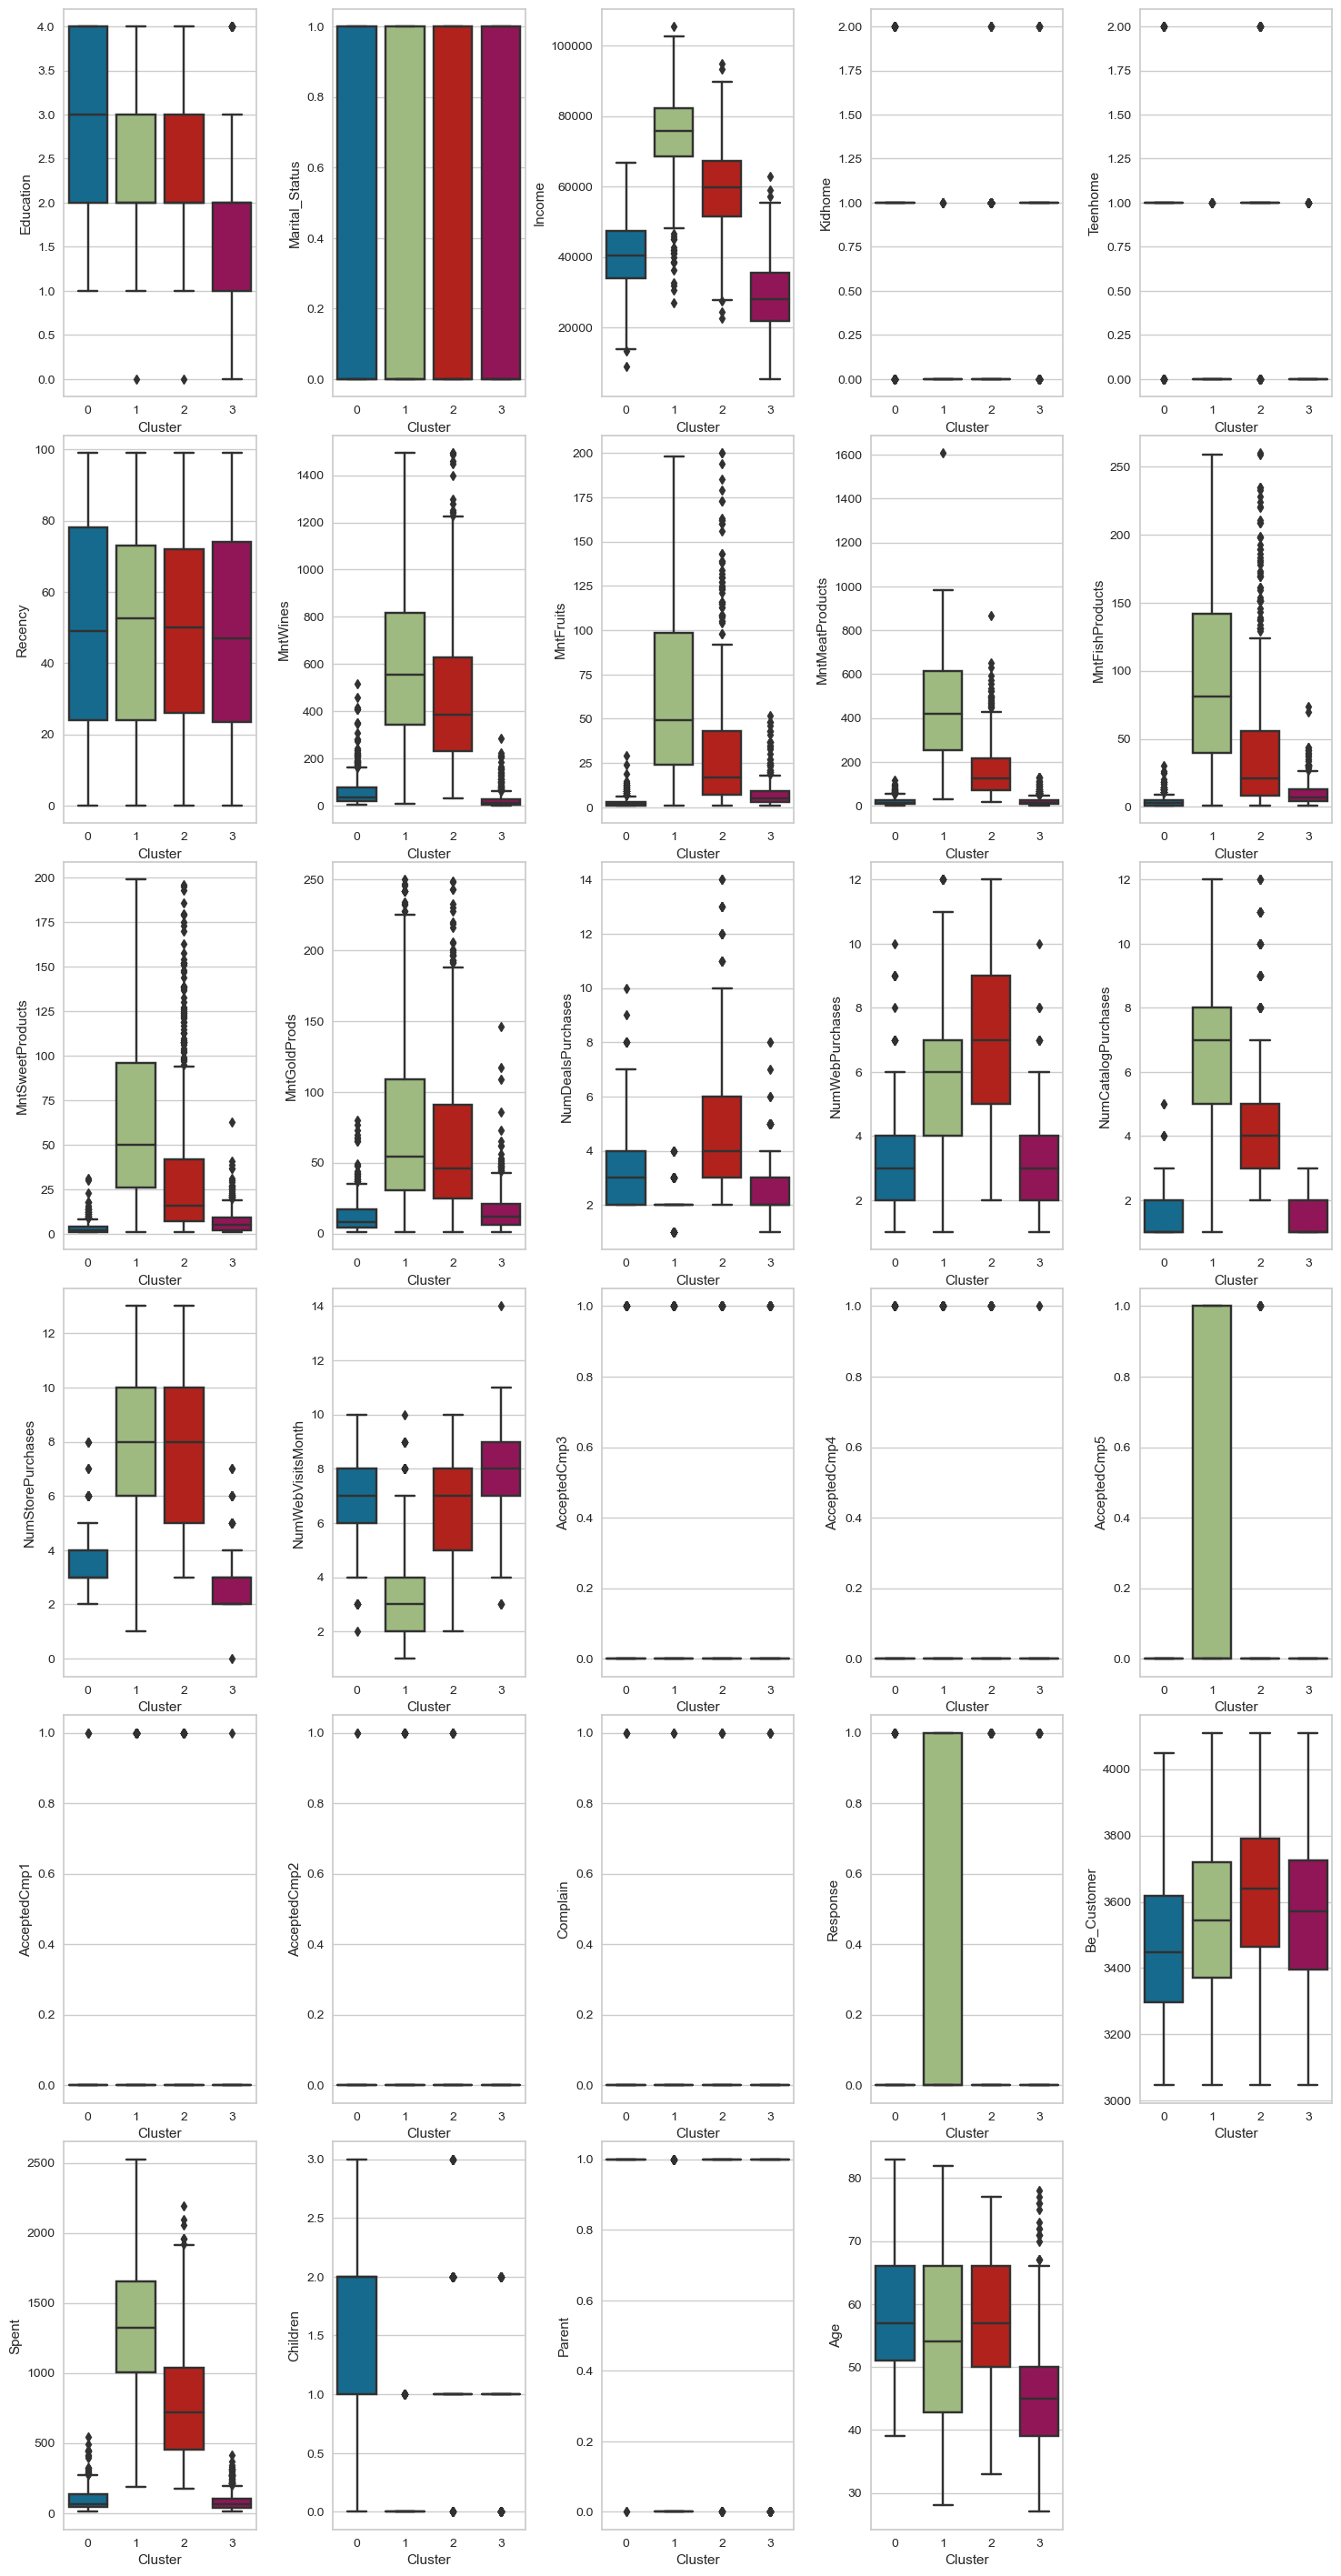

In [53]:
n_features = len(origin_df.columns) - 1
n_columns = 5
n_rows = (n_features + n_columns - 1) // n_columns
fig, axes = plt.subplots(nrows = n_rows, ncols = n_columns, figsize = (18, n_rows * 6))
row, col = 0, 0
for feature in origin_df.columns[:-1]:
    sns.boxplot(x = 'Cluster', y = feature, data = origin_df, ax = axes[row, col])
    col += 1
    
    if col == n_columns:
        col = 0
        row += 1
        
if col != 0:
    for c in range(col, n_columns):
        fig.delaxes(axes[row, c])
        plt.subplots_adjust(hspace = 0.1, wspace = 0.4)

plt.show()

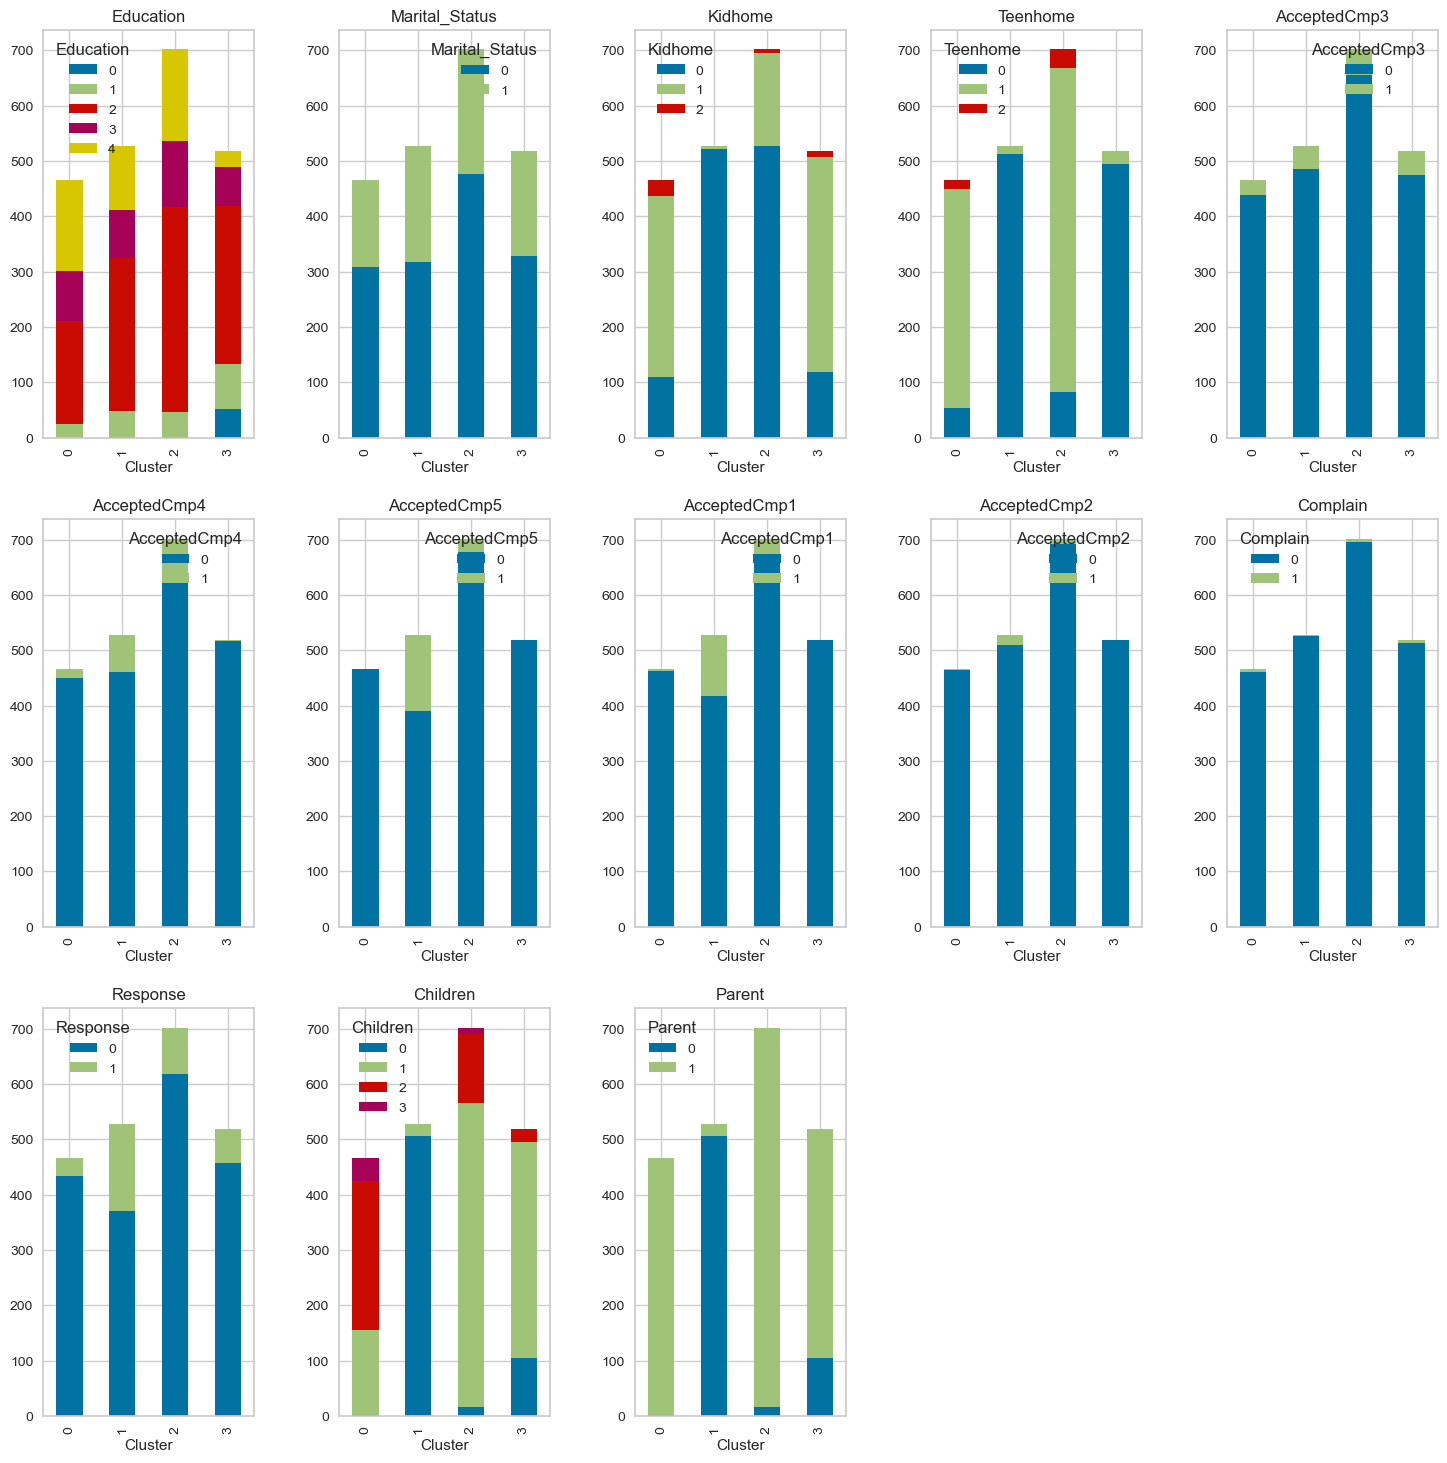

In [65]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (18, 18))
row, col = 0, 0
for feature in origin_df.columns[:-1]:
    if origin_df[feature].nunique() < 10:
        cross_tab = pd.crosstab(origin_df['Cluster'], origin_df[feature])
        cross_tab.plot(kind = 'bar', stacked = True, ax = axes[row, col])
        axes[row, col].set_title(feature)
        col += 1
        if col == 5:
            col = 0
            row += 1
if col != 0:
    for c in range(col, 5):
        fig.delaxes(axes[row, c])
        plt.subplots_adjust(hspace = 0.2, wspace = 0.4)
plt.show()